### Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os

### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


### Checking GPU Access

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the Dataset

In [3]:
train_ds, val_ds, test_ds = tfds.load(
                                      'cifar10',
                                       split = ['train[:40000]', 'train[40000:]', 'test'],
                                       as_supervised = True
)

# Source: https://www.tensorflow.org/datasets/api_docs/python/tfds/load, https://www.tensorflow.org/datasets/splits

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteIE5UMS/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteIE5UMS/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
tf.data.experimental.cardinality(train_ds).numpy(), tf.data.experimental.cardinality(val_ds).numpy(), tf.data.experimental.cardinality(test_ds).numpy()

(40000, 10000, 10000)

### Checking Class Distribution

In [ ]:
def get_class_distribution(ds, num_classes):
  count = [0]*num_classes
  for item in ds:
    count[item[1].numpy()] += 1
  return count

In [ ]:
get_class_distribution(train_ds, 10) # relatively balanced

[4075, 3995, 4006, 3991, 4021, 4011, 4013, 4003, 3976, 3909]

In [ ]:
get_class_distribution(val_ds, 10) # relatively balanced as well

[925, 1005, 994, 1009, 979, 989, 987, 997, 1024, 1091]

### Data Preprocessing

In [4]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

def preprocess(ds, training = True):
  ds = ds.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  if training:
    ds = ds.cache()
    ds = ds.shuffle(40000)
    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.batch(64)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# Source: https://www.tensorflow.org/datasets/keras_example

In [5]:
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds, training = False)
test_ds = preprocess(test_ds, training = False)

### Creating the Model

In [6]:
! pip install git+https://github.com/fversaci/WaveTF.git 

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-j3lienxw
  Running command git clone -q https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-j3lienxw
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25282 sha256=7982af27cab8d41c8aef276bc5e1c73082847773b149f4cc65eac1d3fe4484b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-b15x6g72/wheels/8e/ec/3d/1b322bbe7f99f023e33f5ae0fa6716e29abadde70a3ac6d299
Successfully built WaveTF


In [7]:
from wavetf import WaveTFFactory

In [8]:
class WaveletBlock(layers.Layer):
  def __init__(self, input_channels, wavelet, interpolation, **kwargs):
    super().__init__(**kwargs)
    self.input_channels = input_channels
    self.wavelet = wavelet
    self.interpolation = interpolation
    self.wavelet_transform = WaveTFFactory.build(wavelet)
    self.cA = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cH = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cV = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cD = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.concat = layers.Concatenate(axis = -1)
    self.linear = [layers.Conv2D(filters = input_channels, kernel_size = (1,1), strides = (1,1), padding = 'same'),
                   layers.BatchNormalization()
                  ]
    self.batchnorm = [layers.BatchNormalization(),
                      layers.Activation('relu')]

  def call(self, inputs):
    z = self.wavelet_transform(inputs)

    cA = z[:,:,:,:self.input_channels]
    cV = z[:,:,:,self.input_channels:2*self.input_channels]
    cH = z[:,:,:,2*self.input_channels:3*self.input_channels]
    cD = z[:,:,:,3*self.input_channels:]

    for layer in self.cA:
      cA = layer(cA)
    for layer in self.cV:
      cV = layer(cV) 
    for layer in self.cH:
      cH = layer(cH) 
    for layer in self.cD:
      cD = layer(cD) 
    
    out = self.concat([cA,cV,cH,cD])

    for layer in self.linear:
      out = layer(out)
      
    final = out + inputs

    for layer in self.batchnorm:
      final = layer(final)
    
    return final

In [9]:
def build_cifar10_model(wavelet, interpolation):
  model = Sequential([layers.Input(shape = (32, 32, 3), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      WaveletBlock(input_channels = 32, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_1'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_2'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_3'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'{wavelet}_{interpolation}_model')
  return model

In [10]:
def train_model(model, wavelet, interpolation, initial_epoch = 0, epochs = 100):
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  dir_model = f'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/{wavelet}_{interpolation}_cifar10.h5'
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True, save_weights_only = True)
  with tf.device('/device:GPU:0'):
    history = model.fit(
                        x = train_ds,
                        initial_epoch = initial_epoch,
                        epochs = epochs, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )
  return history

### Haar-Nearest

In [ ]:
haar_nearest = build_cifar10_model('haar', 'nearest')

In [ ]:
haar_nearest.summary()

Model: "haar_nearest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 32, 32, 32)

In [ ]:
haar_nearest_history = train_model(haar_nearest, 'haar', 'nearest')

Epoch 1/100
625/625 [==============================] - 114s 145ms/step - loss: 1.4356 - accuracy: 0.4777 - val_loss: 1.6467 - val_accuracy: 0.4198
Epoch 2/100
625/625 [==============================] - 88s 140ms/step - loss: 1.1068 - accuracy: 0.6046 - val_loss: 1.3236 - val_accuracy: 0.5538
Epoch 3/100
625/625 [==============================] - 88s 141ms/step - loss: 0.9878 - accuracy: 0.6515 - val_loss: 0.9903 - val_accuracy: 0.6463
Epoch 4/100
625/625 [==============================] - 87s 140ms/step - loss: 0.9101 - accuracy: 0.6756 - val_loss: 1.1665 - val_accuracy: 0.6141
Epoch 5/100
625/625 [==============================] - 87s 139ms/step - loss: 0.8522 - accuracy: 0.6999 - val_loss: 1.0457 - val_accuracy: 0.6316
Epoch 6/100
625/625 [==============================] - 88s 140ms/step - loss: 0.8018 - accuracy: 0.7187 - val_loss: 0.9037 - val_accuracy: 0.6868
Epoch 7/100
625/625 [==============================] - 87s 139ms/step - loss: 0.7601 - accuracy: 0.7336 - val_loss: 1.2153 

In [ ]:
haar_nearest.evaluate(test_ds)

157/157 [==============================] - 8s 47ms/step - loss: 0.5853 - accuracy: 0.8308


[0.5852551460266113, 0.8307999968528748]

In [ ]:
haar_nearest_saved = build_cifar10_model('haar', 'nearest')
haar_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_nearest_cifar10.h5')
haar_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 9s 47ms/step - loss: 0.5191 - accuracy: 0.8380


[0.5190855264663696, 0.8379999995231628]

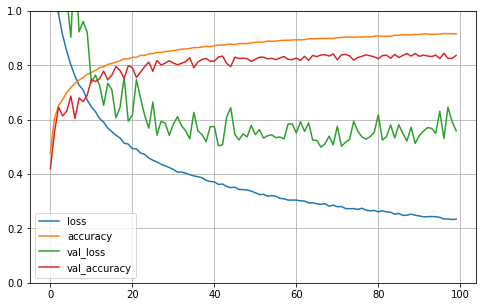

In [ ]:
pd.DataFrame(haar_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
haar_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_nearest_cifar10_last_epoch.h5')

### Haar-Bilinear

In [ ]:
haar_bilinear = build_cifar10_model('haar', 'bilinear')

In [ ]:
haar_bilinear.summary()

Model: "haar_bilinear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 32, 32, 32

In [ ]:
haar_bilinear_history = train_model(haar_bilinear, 'haar', 'bilinear')

Epoch 1/100
625/625 [==============================] - 94s 143ms/step - loss: 1.4303 - accuracy: 0.4805 - val_loss: 1.4800 - val_accuracy: 0.4640
Epoch 2/100
625/625 [==============================] - 89s 143ms/step - loss: 1.1027 - accuracy: 0.6068 - val_loss: 1.1795 - val_accuracy: 0.5800
Epoch 3/100
625/625 [==============================] - 88s 141ms/step - loss: 0.9872 - accuracy: 0.6518 - val_loss: 1.5346 - val_accuracy: 0.5215
Epoch 4/100
625/625 [==============================] - 89s 143ms/step - loss: 0.9135 - accuracy: 0.6802 - val_loss: 0.9577 - val_accuracy: 0.6627
Epoch 5/100
625/625 [==============================] - 89s 142ms/step - loss: 0.8547 - accuracy: 0.6982 - val_loss: 1.2071 - val_accuracy: 0.5854
Epoch 6/100
625/625 [==============================] - 89s 142ms/step - loss: 0.8043 - accuracy: 0.7183 - val_loss: 1.1280 - val_accuracy: 0.6181
Epoch 7/100
625/625 [==============================] - 89s 142ms/step - loss: 0.7594 - accuracy: 0.7369 - val_loss: 0.9961 -

In [ ]:
haar_bilinear.evaluate(test_ds)

157/157 [==============================] - 7s 45ms/step - loss: 0.5370 - accuracy: 0.8377


[0.5370360612869263, 0.8377000093460083]

In [ ]:
haar_bilinear_saved = build_cifar10_model('haar', 'bilinear')
haar_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_bilinear_cifar10.h5')
haar_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 9s 46ms/step - loss: 0.5150 - accuracy: 0.8427


[0.5150160193443298, 0.8427000045776367]

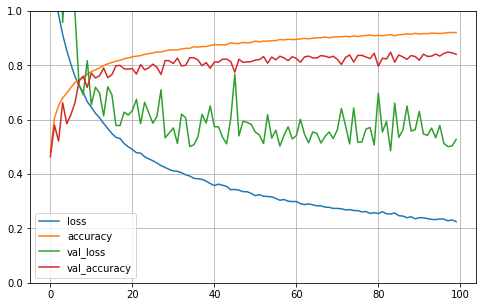

In [ ]:
pd.DataFrame(haar_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
haar_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_bilinear_cifar10_last_epoch.h5')

### DB2-Nearest

In [ ]:
db2_nearest = build_cifar10_model('db2', 'nearest')

In [ ]:
db2_nearest_history = train_model(db2_nearest, 'db2', 'nearest')

Epoch 1/100
625/625 [==============================] - 126s 159ms/step - loss: 1.4277 - accuracy: 0.4812 - val_loss: 1.2424 - val_accuracy: 0.5483
Epoch 2/100
625/625 [==============================] - 97s 155ms/step - loss: 1.1045 - accuracy: 0.6079 - val_loss: 1.2592 - val_accuracy: 0.5613
Epoch 3/100
625/625 [==============================] - 95s 152ms/step - loss: 0.9881 - accuracy: 0.6480 - val_loss: 1.0808 - val_accuracy: 0.6194
Epoch 4/100
625/625 [==============================] - 95s 151ms/step - loss: 0.9235 - accuracy: 0.6706 - val_loss: 1.0862 - val_accuracy: 0.6264
Epoch 5/100
625/625 [==============================] - 95s 152ms/step - loss: 0.8599 - accuracy: 0.6977 - val_loss: 1.0837 - val_accuracy: 0.6249
Epoch 6/100
625/625 [==============================] - 95s 152ms/step - loss: 0.8162 - accuracy: 0.7108 - val_loss: 0.9054 - val_accuracy: 0.6793
Epoch 7/100
625/625 [==============================] - 94s 151ms/step - loss: 0.7845 - accuracy: 0.7222 - val_loss: 1.1073 

In [ ]:
db2_nearest.evaluate(test_ds)

157/157 [==============================] - 9s 55ms/step - loss: 0.5605 - accuracy: 0.8304


[0.5604554414749146, 0.8303999900817871]

In [ ]:
db2_nearest_saved = build_cifar10_model('db2', 'nearest')
db2_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_nearest_cifar10.h5')
db2_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 10s 52ms/step - loss: 0.5065 - accuracy: 0.8336


[0.5064799189567566, 0.8335999846458435]

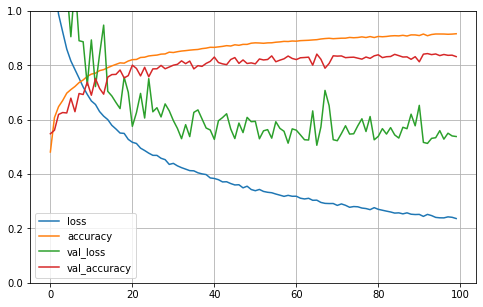

In [ ]:
pd.DataFrame(db2_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
db2_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_nearest_cifar10_last_epoch.h5')

### DB2-Bilinear

In [11]:
db2_bilinear = build_cifar10_model('db2', 'bilinear')

In [12]:
db2_bilinear_history = train_model(db2_bilinear, 'db2', 'bilinear')

Epoch 1/100
625/625 [==============================] - 128s 169ms/step - loss: 1.4729 - accuracy: 0.4582 - val_loss: 1.8451 - val_accuracy: 0.3905
Epoch 2/100
625/625 [==============================] - 101s 162ms/step - loss: 1.1275 - accuracy: 0.5953 - val_loss: 1.2230 - val_accuracy: 0.5689
Epoch 3/100
625/625 [==============================] - 102s 162ms/step - loss: 1.0108 - accuracy: 0.6399 - val_loss: 1.1690 - val_accuracy: 0.5824
Epoch 4/100
625/625 [==============================] - 101s 161ms/step - loss: 0.9305 - accuracy: 0.6711 - val_loss: 1.1917 - val_accuracy: 0.5898
Epoch 5/100
625/625 [==============================] - 101s 162ms/step - loss: 0.8726 - accuracy: 0.6921 - val_loss: 0.9743 - val_accuracy: 0.6533
Epoch 6/100
625/625 [==============================] - 101s 161ms/step - loss: 0.8368 - accuracy: 0.7066 - val_loss: 0.9913 - val_accuracy: 0.6463
Epoch 7/100
625/625 [==============================] - 101s 162ms/step - loss: 0.7949 - accuracy: 0.7193 - val_loss: 0

In [13]:
db2_bilinear.evaluate(test_ds)

157/157 [==============================] - 9s 57ms/step - loss: 0.6197 - accuracy: 0.8208


[0.6197478771209717, 0.8208000063896179]

In [14]:
db2_bilinear_saved = build_cifar10_model('db2', 'bilinear')
db2_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_bilinear_cifar10.h5')
db2_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 10s 52ms/step - loss: 0.5311 - accuracy: 0.8323


[0.5311080813407898, 0.8323000073432922]

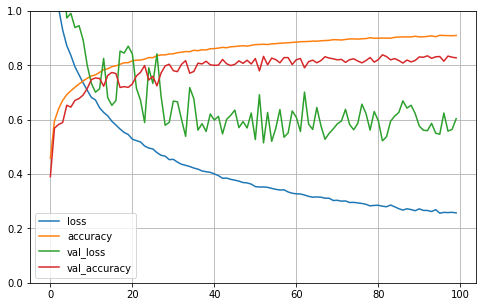

In [15]:
pd.DataFrame(db2_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [16]:
db2_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_bilinear_cifar10_last_epoch.h5')

### Fully Conv

In [ ]:
fully_conv = Sequential([layers.Input(shape = (32, 32, 3), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_5'),
                      layers.BatchNormalization(name = 'conv2d_5_bn'),
                      layers.Activation('relu', name = 'conv2d_5_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_6'),
                      layers.BatchNormalization(name = 'conv2d_6_bn'),
                      layers.Activation('relu', name = 'conv2d_6_relu'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_7'),
                      layers.BatchNormalization(name = 'conv2d_7_bn'),
                      layers.Activation('relu', name = 'conv2d_7_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'fully_conv_model')

In [ ]:
fully_conv.summary()

Model: "fully_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)   

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
fully_conv.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
dir_model = 'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/fully_conv_cifar10.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True)
with tf.device('/device:GPU:0'):
  fully_conv_history = fully_conv.fit(
                        x = train_ds,
                        epochs = 100, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )

Epoch 1/100
625/625 [==============================] - 67s 77ms/step - loss: 1.5445 - accuracy: 0.4297 - val_loss: 1.5597 - val_accuracy: 0.4566
Epoch 2/100
625/625 [==============================] - 29s 46ms/step - loss: 1.1735 - accuracy: 0.5781 - val_loss: 1.3367 - val_accuracy: 0.5293
Epoch 3/100
625/625 [==============================] - 29s 46ms/step - loss: 1.0261 - accuracy: 0.6355 - val_loss: 1.0825 - val_accuracy: 0.6086
Epoch 4/100
625/625 [==============================] - 28s 45ms/step - loss: 0.9322 - accuracy: 0.6685 - val_loss: 1.2638 - val_accuracy: 0.5617
Epoch 5/100
625/625 [==============================] - 29s 46ms/step - loss: 0.8761 - accuracy: 0.6909 - val_loss: 1.0517 - val_accuracy: 0.6468
Epoch 6/100
625/625 [==============================] - 28s 45ms/step - loss: 0.8130 - accuracy: 0.7161 - val_loss: 1.2394 - val_accuracy: 0.5979
Epoch 7/100
625/625 [==============================] - 29s 46ms/step - loss: 0.7723 - accuracy: 0.7288 - val_loss: 0.8695 - val_ac

In [ ]:
fully_conv.evaluate(test_ds)    

157/157 [==============================] - 3s 18ms/step - loss: 0.6600 - accuracy: 0.8224


[0.6599506139755249, 0.8223999738693237]

In [ ]:
fully_conv_saved = keras.models.load_model('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/fully_conv_cifar10.h5')
fully_conv_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fully_conv_saved.evaluate(test_ds)

157/157 [==============================] - 3s 14ms/step - loss: 0.4816 - accuracy: 0.8506


[0.48156577348709106, 0.850600004196167]

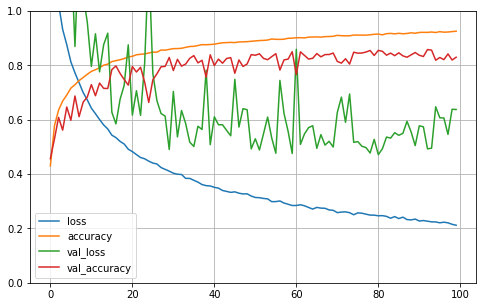

In [ ]:
pd.DataFrame(fully_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
fully_conv.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/fully_conv_cifar10_last_epoch.h5')